In [1]:
%load_ext autoreload
%autoreload 2

# Experimental 001

## Setup

In [2]:
from multiprocessing import process
from athena_analyze.data.processor import DataProcessor
from utils.logging import setup_logging
from utils.config import load_config_section, load_config

_log = setup_logging()
data_cfg = load_config_section("../config/config.yml", "data")
processor = DataProcessor(data_fol=data_cfg["raw"])
dfs = []
dfs.append(processor.load_data("ETTh1.csv"))
dfs.append(processor.load_data("ETTh2.csv"))

exp_name = "exp_001"
general_cfg_path = "../config/config.yml"
exp_cfg_path = "../config/exp_001.yml"

2026-02-05 13:06:38,705 - athena-assignment - DEBUG - DataProcessor initialized with data folder: ../data/raw


# Preprocess

MSTLを用いて周期性の分解を行う。

In [ ]:
from pathlib import Path
pp_general_cfg = load_config_section(general_cfg_path, "preprocess")
pp_exp_cfg = load_config_section(exp_cfg_path, "preprocess")

train_dfs = []
test_dfs = []

if Path(f"../data/experiment/{exp_name}/train_h1.parquet").exists() == True:
    _log.warning(f"Experiment folder ../data/experiment/{exp_name} already exists.")
    for name in ["train_h1", "train_h2", "test_h1", "test_h2"]:
        _log.info(f"Loading dataset {name}")
        df = processor.load_data(f"{exp_name}/{name}.parquet",
                                 data_folder=Path("../data/experiment"))
        if "train" in name:
            train_dfs.append(df)
        else:
            test_dfs.append(df)
else:
    for i, df in enumerate(dfs):
        _log.info(f"Processing dataset {i}")
        pp_cfg = dict(**pp_general_cfg, **pp_exp_cfg[f"h{i+1}"])
        train_df, test_df = processor.preprocess_data(df, **pp_cfg)
        train_dfs.append(train_df)
        test_dfs.append(test_df)

    from utils.data_io import save_dataframe_to_parquet
    data_cfg = load_config_section("../config/config.yml", "data")

    for df, name in zip(train_dfs + test_dfs, ["train_h1", "train_h2", "test_h1", "test_h2"]):
        save_dataframe_to_parquet(df, f"{exp_name}/{name}.parquet", config=data_cfg)

2026-02-05 13:06:38,890 - athena-assignment - INFO - Processing dataset 0
2026-02-05 13:06:38,891 - athena-assignment - DEBUG - Starting data preprocessing
2026-02-05 13:06:38,894 - athena-assignment - DEBUG - Dropped NA values, remaining rows: 17420
2026-02-05 13:06:38,915 - athena-assignment - DEBUG - Dropped duplicate rows, remaining rows: 17420
2026-02-05 13:06:38,916 - athena-assignment - INFO - Data Cleaning completed, starting Data Splitting
2026-02-05 13:06:38,944 - athena-assignment - DEBUG - Data split at {'train_start': '2016-07-01 00:00:00', 'train_end': '2018-02-01 13:59:59', 'test_start': '2018-02-01 14:00:00', 'test_end': '2018-06-26 19:00:00'}: 13934 training rows, 3486 testing rows
2026-02-05 13:06:38,944 - athena-assignment - INFO - Data Splitting completed
2026-02-05 13:06:38,945 - athena-assignment - DEBUG - Adding features: ['date_features', 'season', 'lag_features']
2026-02-05 13:06:38,973 - athena-assignment - DEBUG - Added 'year', 'month', 'day', 'weekday', 'yea

2026-02-05 14:16:29,779 - athena-assignment - DEBUG - Plotting time series for columns: ['OT', 'stl_OT_seasonal_24', 'stl_OT_seasonal_2160', 'stl_OT_resid', 'stl_OT_trend'] with date column: date


/var/folders/mr/9ycqbh915_5f4hxrq1w5yh6m0000gq/T/ipykernel_93079/1118345557.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


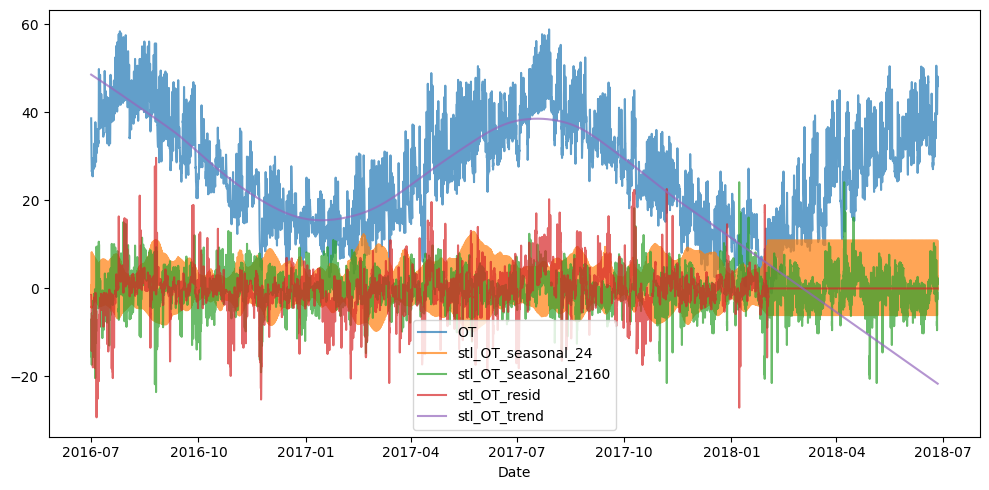

In [4]:
from athena_analyze.eda.visualize import plot_time_series
import pandas as pd

plot_df = pd.concat(
    [
        train_dfs[1],
        test_dfs[1],
    ]
)
fig = plot_time_series(df=plot_df, date_col="date",
                       value_cols=["OT", "stl_OT_seasonal_24",
                                   "stl_OT_seasonal_2160", "stl_OT_resid", "stl_OT_trend"])
fig.show()

## Model Training

LightGBMモデルをOptunaによるハイパーパラメータチューニングで学習する。

In [9]:
from athena_analyze.models.base import ModelRegistry

model_cfg = load_config_section(exp_cfg_path, "models")

registry = ModelRegistry()
registry.auto_discover()
registry.list_models()

each_model_cfg = [k for k in model_cfg.keys() if k in model_cfg["general"]["models"]]
trained_models = []

for model_name, each_cfg in zip(model_cfg["general"]["models"], each_model_cfg):
    print(f"Training model: {each_cfg}")
    model_cls = registry.get_model(model_name)
    model = model_cls(config=model_cfg[each_cfg])

    target_col = model_cfg[each_cfg].get("target_col", "OT")
    drop_cols = [target_col, "date"]
    feature_cols = [c for c in train_dfs[1].columns if c not in drop_cols]

    X_train = train_dfs[1][feature_cols]
    y_train = train_dfs[1][target_col]
    X_valid = test_dfs[1][feature_cols]
    y_valid = test_dfs[1][target_col]

    model.train(X_train, y_train, valid_data=X_valid, valid_label=y_valid)
    trained_models.append((each_cfg, model))

print("Training complete.")

2026-02-05 14:31:54,957 - athena-assignment - DEBUG - Auto-discovering models in directory: /Users/teramoto/dev/github/YHTR0257/athena-assignment/src/athena_analyze/models
Training model: light_gbm
2026-02-05 14:31:54,961 - athena-assignment - INFO - Config validation for LightGBM model passed.


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `

2026-02-05 14:32:08,157 - athena-assignment - INFO - Optuna best params: {'learning_rate': 0.10189931591540446, 'num_leaves': 73, 'bagging_fraction': 0.7016209362897721, 'min_child_samples': 93, 'bagging_freq': 4, 'feature_fraction': 0.9539903286065194}
2026-02-05 14:32:08,159 - athena-assignment - INFO - Optuna best RMSE: 0.790382784035099
Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 3.72632
[20]	valid_0's rmse: 1.48058
[30]	valid_0's rmse: 0.902243
[40]	valid_0's rmse: 0.790383
[50]	valid_0's rmse: 0.86247
[60]	valid_0's rmse: 0.899187
[70]	valid_0's rmse: 0.912392
[80]	valid_0's rmse: 0.893616
[90]	valid_0's rmse: 0.951462
Early stopping, best iteration is:
[40]	valid_0's rmse: 0.790383
2026-02-05 14:32:08,681 - athena-assignment - INFO - LightGBM model trained successfully.
Training complete.


## Model Params

学習させたモデルのパラメータを読み込みする。

In [10]:
from pathlib import Path

models_dir = Path(f"../models/{exp_name}")
models_dir.mkdir(parents=True, exist_ok=True)

for name, model in trained_models:
    save_path = str(models_dir / f"{name}.txt")
    model.save_model(save_path)
    info = model.get_info()
    print(f"--- {name} ---")
    print(f"Model Type: {info['model_type']}")
    print(f"Num Trees: {info.get('num_trees')}")
    if info.get('best_params'):
        print(f"Best Params: {info['best_params']}")
    if info.get('optuna_best_value'):
        print(f"Optuna Best RMSE: {info['optuna_best_value']:.4f}")
    print(f"Saved to: {save_path}")
    print()

2026-02-05 14:34:33,568 - athena-assignment - INFO - Model saved to ../models/exp_001/light_gbm.txt
--- light_gbm ---
Model Type: LightGBM
Num Trees: 40
Best Params: {'learning_rate': 0.10189931591540446, 'num_leaves': 73, 'bagging_fraction': 0.7016209362897721, 'min_child_samples': 93, 'bagging_freq': 4, 'feature_fraction': 0.9539903286065194}
Optuna Best RMSE: 0.7904
Saved to: ../models/exp_001/light_gbm.txt



## Evaluation

モデルの評価を行う。
- MAPE, RMSE, MAE, R2

In [11]:
for name, model in trained_models:
    target_col = model_cfg[name].get("target_col", "OT")
    drop_cols = [target_col, "date"]
    feature_cols = [c for c in test_dfs[1].columns if c not in drop_cols]

    X_test = test_dfs[1][feature_cols]
    y_test = test_dfs[1][target_col]

    eval_result = model.evaluate(X_test, y_test)
    print(f"--- {name} ---")
    for metric, value in eval_result.items():
        print(f"  {metric}: {value:.4f}")

--- light_gbm ---
  mape: 13.6580
  rmse: 0.9273
  mae: 0.7493
  r2: 0.9925
